# 1. IMPORTS

In [1]:
# misc libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn classes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier


# 2. Dataset generation

## Constant and functions

In [2]:
ROOT_DIR= '/mnt/d/NOTES-ARCHIVE/PROJECT3/Code/Dataset_distilled'
LABELS= ["Benign","Bruteforce","Dos/DDos","Mirai","Recon","Spoofing","Web-based"]

In [3]:
single_value_cols = []
def is_unique(s):                           #   This runs in O(n) compared to O(n log n) nunique() method
    a = s.to_numpy() 
    return (a[0] == a).all()

In [4]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    return 1

## Loading and dropping column with single-value

In [5]:
df = pd.read_csv(f'{ROOT_DIR}/distilled_feature_dataset.csv')

In [6]:
for i in df.columns:
    if(is_unique(df[i])):
        single_value_cols.append(i)
df.drop(single_value_cols,axis=1, inplace=True) 

In [1]:
# Display the original class distribution
print(df['class'].value_counts(ascending=True))

NameError: name 'df' is not defined

<Axes: >

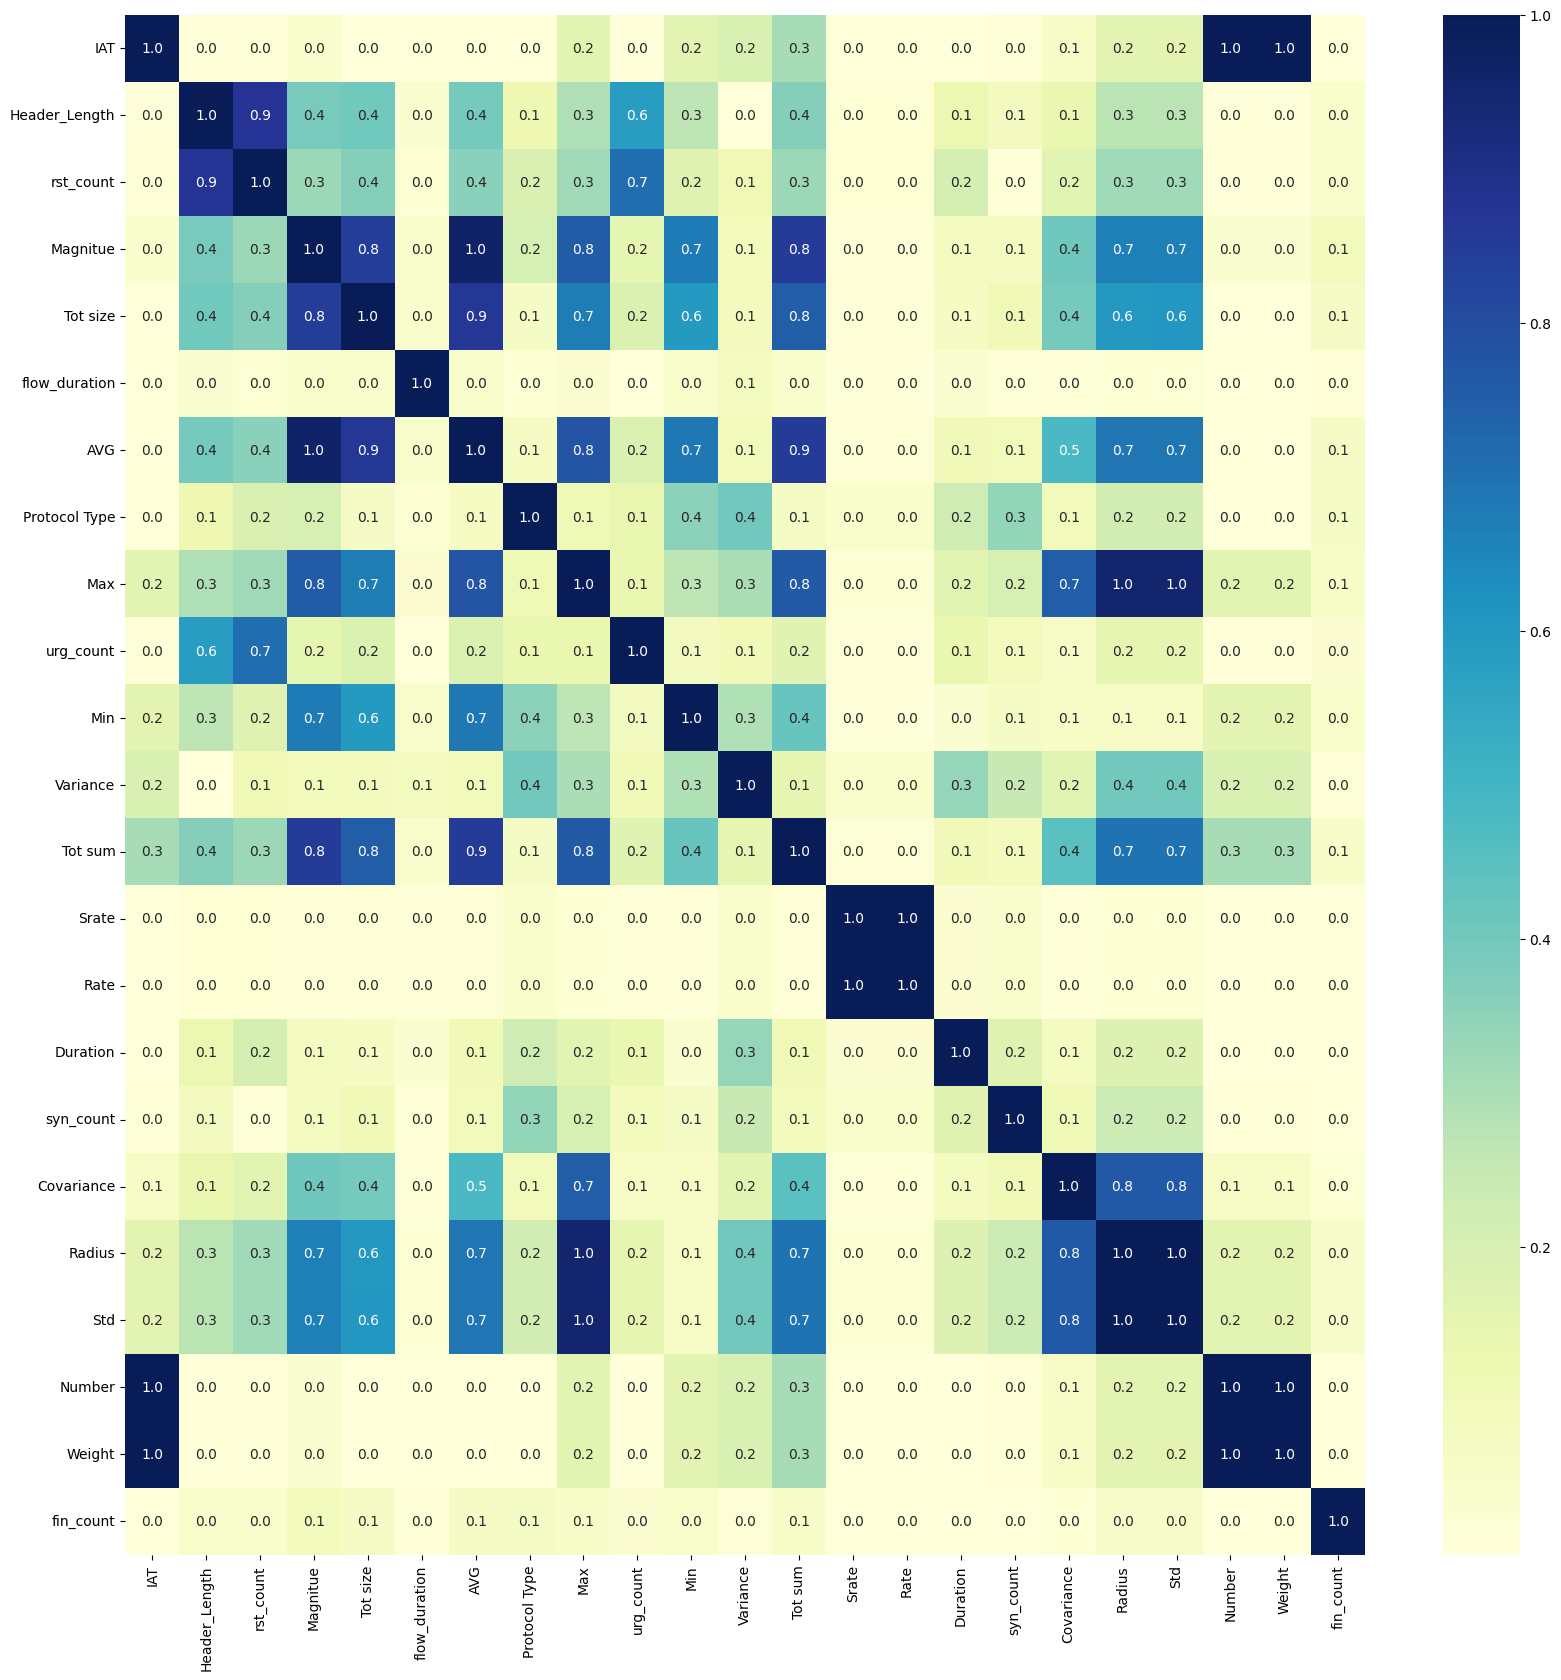

In [8]:
# Display the detailed correlation matrix.
corr = df.iloc[:,:-1].corr().abs()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt=".1f", cmap="YlGnBu")


In [9]:
# Display number of columns
num_columns = df.shape[1]

# Output the number of columns
print(f"The number of columns in the DataFrame is: {num_columns}")

The number of columns in the DataFrame is: 24


## Split into training and testing set

In [10]:
sub_df = df  

# remove nan, inf, -inf value
sub_df = sub_df[~sub_df.isin([np.nan, np.inf, -np.inf]).any(axis=1)] 

In [11]:
X = sub_df.iloc[:,:-1]
Y = sub_df.iloc[:,-1]

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=random.randint(1,999))
print(X_train.shape,X_test.shape)

(54035, 23) (13509, 23)


## Data scaling

In [13]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Random forest

## Training
- From n_estimators > 1000, the model performance stays relatively the same

In [14]:
# RF_clf = RandomForestClassifier(n_estimators=200,max_depth=20, max_leaf_nodes=1000,n_jobs=-1)
RF_clf = RandomForestClassifier(n_estimators=1000,n_jobs=-1)
RF_clf.fit(X_train_scaled, Y_train)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

## Random-forest benchmark

              precision    recall  f1-score   support

      Benign       0.87      0.90      0.88      2062
  Bruteforce       0.83      0.84      0.83      1568
    Dos/DDos       1.00      1.00      1.00      2014
       Mirai       1.00      1.00      1.00      1990
       Recon       0.89      0.78      0.83      1940
    Spoofing       0.92      0.83      0.87      1932
   Web-based       0.80      0.93      0.86      2003

    accuracy                           0.90     13509
   macro avg       0.90      0.90      0.90     13509
weighted avg       0.90      0.90      0.90     13509



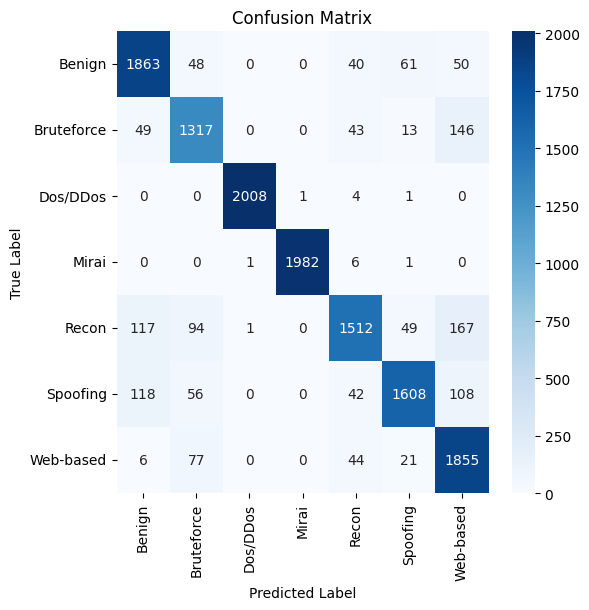

1

In [15]:
RF_clf_Y_pred = RF_clf.predict(X_test_scaled)
print(classification_report(Y_test, RF_clf_Y_pred))
plot_confusion_matrix(Y_test,RF_clf_Y_pred)
# ConfusionMatrixDisplay.from_predictions(Y_test, RF_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 4. SGDC 

## Training 
- According to different scaling methods used above, the model is consistently performed at its best when paired with the PowerTransformer scaling method

In [16]:
SGDC_clf = make_pipeline(PowerTransformer(),SGDClassifier(max_iter=10000, tol=1e-5,n_jobs=-2))
SGDC_clf.fit(X_train_scaled,Y_train)

Pipeline(steps=[('powertransformer', PowerTransformer()),
                ('sgdclassifier',
                 SGDClassifier(max_iter=10000, n_jobs=-2, tol=1e-05))])

## SGDC benchmark

              precision    recall  f1-score   support

      Benign       0.56      0.74      0.64      2062
  Bruteforce       0.29      0.12      0.16      1568
    Dos/DDos       0.93      0.97      0.95      2014
       Mirai       0.99      0.99      0.99      1990
       Recon       0.60      0.37      0.46      1940
    Spoofing       0.54      0.53      0.53      1932
   Web-based       0.50      0.73      0.59      2003

    accuracy                           0.65     13509
   macro avg       0.63      0.64      0.62     13509
weighted avg       0.64      0.65      0.63     13509



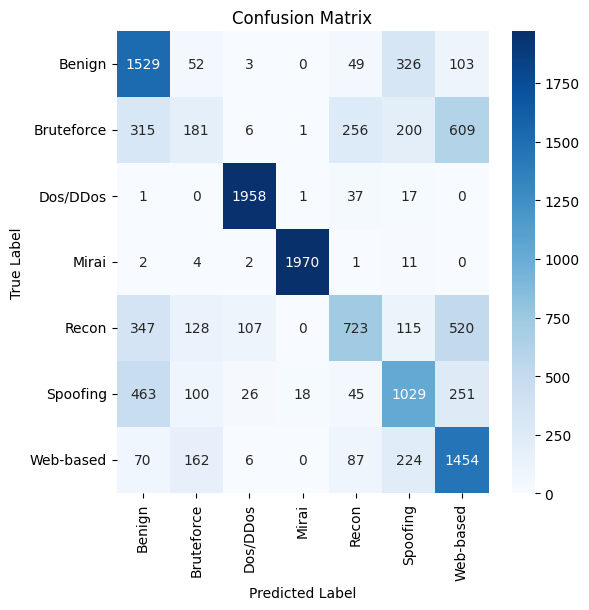

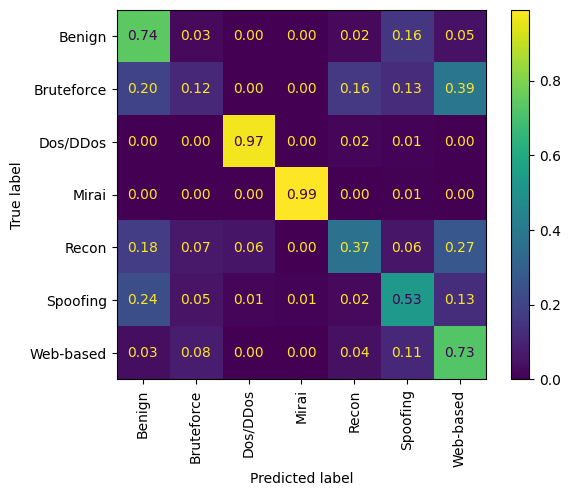

In [17]:
SGDC_clf_Y_pred = SGDC_clf.predict(X_test_scaled)
print(classification_report(Y_test, SGDC_clf_Y_pred))
plot_confusion_matrix(Y_test,SGDC_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, SGDC_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')

# 5. MLP


## Training

In [19]:
mlp = MLPClassifier(
  hidden_layer_sizes=(128,),
  activation='relu',
  alpha=0.0001,
  solver='adam',
  learning_rate='constant',
  learning_rate_init=0.0002,
  max_iter=10000,
  random_state=42
)
mlp.fit(X_train_scaled, Y_train)

MLPClassifier(hidden_layer_sizes=(128,), learning_rate_init=0.0002,
              max_iter=10000, random_state=42)

## Benchmark

              precision    recall  f1-score   support

      Benign       0.72      0.81      0.76      2062
  Bruteforce       0.56      0.53      0.54      1568
    Dos/DDos       1.00      1.00      1.00      2014
       Mirai       1.00      0.99      1.00      1990
       Recon       0.74      0.57      0.64      1940
    Spoofing       0.84      0.64      0.73      1932
   Web-based       0.60      0.82      0.69      2003

    accuracy                           0.78     13509
   macro avg       0.78      0.77      0.77     13509
weighted avg       0.79      0.78      0.77     13509



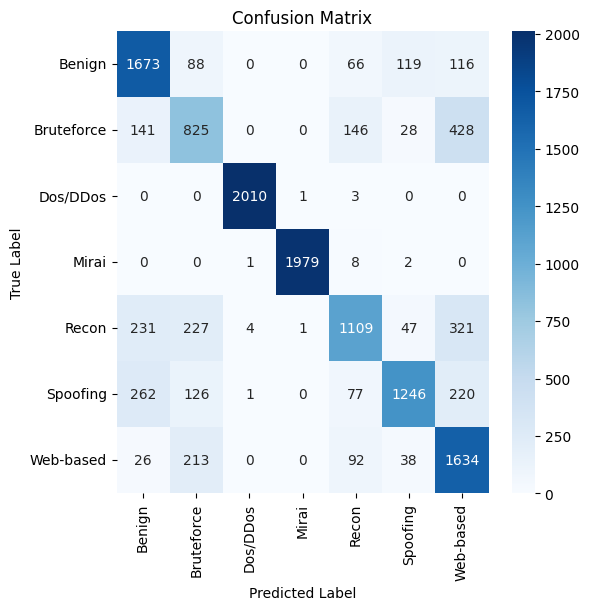

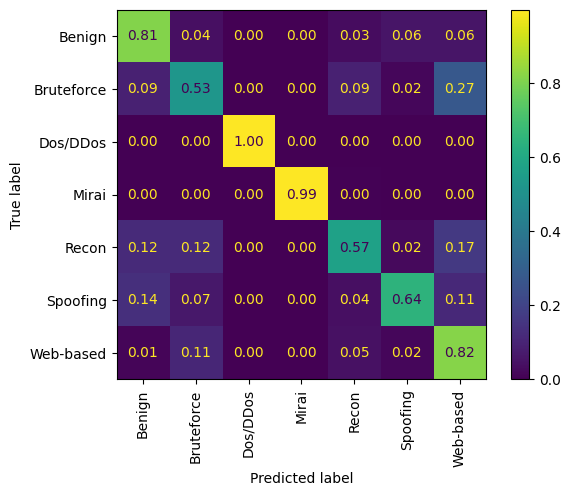

In [21]:
MLP_clf_Y_pred = mlp.predict(X_test_scaled)
print(classification_report(Y_test, MLP_clf_Y_pred))
plot_confusion_matrix(Y_test,MLP_clf_Y_pred)
ConfusionMatrixDisplay.from_predictions(Y_test, MLP_clf_Y_pred, normalize='true',values_format='.2f', xticks_rotation='vertical')